# Cross correlation with Quasar Catalog - Assef WISE AGN cat

In [1]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from cmass_modules import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def catalog_masking(cat, nside_out = 128, area=None):
    print 'input cat ', cat.size
    cat = reddening_mask(cat = cat, nside_out = nside_out)
    print 'reddening ', cat.size
    if area is 'NGC' :
        cat = boss_mask(cat=cat, nside_out = nside_out, area=area)
    elif area is 'SGC' :
        cat = boss_mask(cat=cat, nside_out = nside_out, area=area)    
    elif area is 'SPT':
        cat = Cuts.keepGoodRegion(cat)
        cat = cat[cat['DEC']<-3.0]
        #cat = y1gold_mask(cat = cat, nside_out = nside_out)
    else : print 'area keyword input : either one of NGC SGC SPT'
        
    print 'output ', cat.size
    return cat

In [3]:
def making_healpix_density_map(cat = None, nside = 128, nest = False):
    hpind = np.arange(hp.nside2npix(nside))
    cat_ind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside, nest= nest)
    N_gal, _ = np.histogram(cat_ind, bins = np.append(hpind, hpind.size) )
    unseen = (N_gal != 0.0)
    pixarea = hp.nside2pixarea(nside = nside)
    ra,dec = hpHEALPixelToRaDec(hpind, nside = nside)
    Map = np.zeros( (hpind.size, ), dtype = [('RA', 'float'),('DEC', 'float'),('PIXEL', 'float'), ('N_GAL', 'float') \
                                            , ('WEIGHT', 'float') , ('WEIGHT_RAND', 'bool') ])
    Map['RA'] = ra
    Map['DEC'] = dec
    Map['PIXEL'] = hpind
    Map['N_GAL'] = N_gal*1./pixarea    
    Map['WEIGHT'] = N_gal*1./pixarea 
    Map['WEIGHT_RAND'] = unseen
    return Map

In [4]:
def y1gold_mask(cat=None, nside_out = 4096):
    
    path = '/n/des/lee.5922/data/systematic_maps/'
    LSSGoldmask_hpind = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')['PIXEL']
    hpind_frac = np.zeros(hp.nside2npix(4096), dtype = 'float')
    hpind_frac[LSSGoldmask_hpind] = 1.0
    if nside_out == 4096 : hpind_frac_ud = hpind_frac
    else : hpind_frac_ud = hp.ud_grade(hpind_frac, pess=True, nside_out = nside_out)
    
    hpind_up = np.arange(hp.nside2npix(nside_out))
    
    cat = cat[cat['DEC']<-3.0]
    cat_hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside_out, nest= False) 
    goodind = np.in1d(cat_hpind, hpind_up[[ hpind_frac_ud > 0.8]])
    return cat[goodind]  

In [5]:
def boss_mask(cat=None, area='SGC', nside_out = 1024):
    

    if area is 'SGC' : 
        boss_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_SGC_1024.fits')
        
        #boss_hpind = hp.ud_grade(boss_hpind, pess=True, nside_out = nside)

    elif area is 'NGC':
        boss_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_NGC_1024.fits')
        #boss_hpind = hp.ud_grade(boss_hpind, pess=True, nside_out = nside)
    else : 
        print 'area keyword input : SGC or NGC'
        return 0
     
    boss_hpfrac = np.zeros(hp.nside2npix(1024), dtype = 'float')
    boss_hpfrac[boss_hpind] = 1.0
    boss_hpind_up = np.arange(hp.nside2npix(nside_out))
    
    if nside_out == 1024 : boss_hpfrac_ud = boss_hpfrac
    else : boss_hpfrac_ud = hp.ud_grade(boss_hpfrac, pess=True, nside_out = nside_out)
    
    #print boss_hpfrac
    
    
    #boss_hpfrac_ud2 = boss_hpfrac_ud.copy()
    #boss_hpfrac_ud2[ boss_hpfrac_ud > 0.8] = 0
    #hp.mollview( boss_hpfrac_ud2, max = 1, nest = False)
    
    #if cat is None : 
    #    boss_hpmask = np.zeros(hp.nside2npix(4096), dtype = 'bool')
    #    boss_hpmask[boss_hpind] = 1
    #    return boss_hpmask
    
    #elif cat is not None : 
        
    hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside_out, nest= False) 
    goodind = np.in1d(hpind, boss_hpind_up[[ boss_hpfrac_ud > 0.8]])
    return cat[goodind]

In [6]:
def wise_mask(cat=None):
    wise_hpind = fitsio.read('/n/des/lee.5922/data/wise_cat/mask_wise_agn_nside128.fits')
    cat_hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= 128, nest= False) 
    goodind = np.in1d(cat_hpind, wise_hpind )
    return cat[goodind]      

In [7]:
def moon_cont_mask(cat):
    
    mask = np.zeros(cat.size, dtype = 'bool') #(cat['MOON_LEV']=='0000')
    #combinations = []
    for i in [0,1,2]:
        for j in [0,1,2]:
            for k in [0,1,2]:
                for l in [0,1,2]:
                    filt = '{}{}{}{}'.format(i,j,k,l)
                    mask +=(cat['MOON_LEV']==filt)
    return mask
 

## Calling WISE AGN

In [8]:
import esutil

In [9]:
agn = esutil.io.read('/n/des/lee.5922/data/wise_cat/wiseagn_r90.fits', upper=True, ensure_native=True )

In [12]:
wise = esutil.io.read('/n/des/lee.5922/data/wise_cat/wise_allsky.allsky_4band_p3as_psd25158.fits',  upper=True)
HealInds = hpRaDecToHEALPixel(wise['RA'], wise['DEC'], nside=  512, nest= False)

wise = rf.append_fields(wise,'HEALIndex',HealInds,dtypes=HealInds.dtype)
cont_mask = moon_cont_mask(wise)
moonrevHPind = wise['HEALIndex'][cont_mask]
wise = None
#wise = wise[cont_mask]
#wise = wise[(wise['CC_FLAGS'] != '0000')]

In [11]:
def moonrev_mask(moonrevHPind, cat):
    #catHPind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=  512, nest= False)
    #hpmask = np.in1d( catHPind, moonrevHPind )   
    #return cat[cat['MOON-SAA_FLAG'] == 0  ]
    return cat #[hpmask]

In [128]:
agn = moonrev_mask(moonrevHPind, agn)

In [104]:
#validpix = agn_galmap['PIXEL'][ agn_galmap['WEIGHT'] != 0.0 ]
#fitsio.write('/n/des/lee.5922/data/wise_cat/mask_wise_agn_nside128.fits',validpix, clobber=True)

In [114]:
agn.size

4497284

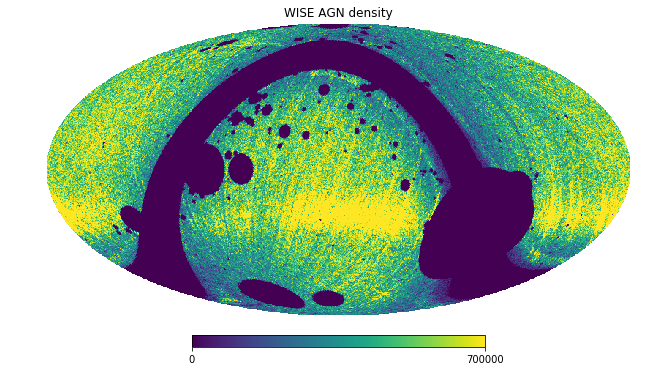

In [11]:
agn_galmap= making_healpix_density_map(cat = agn, nside = 128, nest = False)
hp.mollview(agn_galmap['WEIGHT'], nest=False, title="WISE AGN density", max = 7e5)

### Cross correlation with CMASS SGC

In [25]:
cmass_sgc , random_sgc = None, None

In [13]:
#CMASS SGC
path = '/n/des/lee.5922/data/cmass_cat/'
cmass = esutil.io.read(path+'galaxy_DR12v5_CMASS_South.fits.gz')
#cmass = esutil.io.read(path+'galaxy_DR12v5_CMASS_North.fits.gz')
random = esutil.io.read(path+'random0_DR12v5_CMASS_South.fits.gz')
#random = esutil.io.read(path+'random0_DR12v5_CMASS_North.fits.gz')

#cmass = cmass_ngc
#random = random_ngc

#w_sgc = cmass['WEIGHT_FKP'] * cmass['WEIGHT_SYSTOT']*( cmass['WEIGHT_CP'] + cmass['WEIGHT_NOZ'] - 1. )
#w_rand = random['WEIGHT_FKP']
#cmass = rf.append_fields(cmass,'WEIGHT', w_sgc, dtypes=w_sgc.dtype)
#random = rf.append_fields(random,'WEIGHT_RAND', w_rand, dtypes=w_rand.dtype)

cmass = boss_mask(cat=cmass, area='SGC')
random = boss_mask(cat=random, area='SGC')

cmass = wise_mask(cat=cmass)
random = wise_mask(cat=random)


#cmass= moonrev_mask(moonrevHPind, cmass)
#random= moonrev_mask(moonrevHPind, random)

In [14]:
agn_boss = boss_mask(cat=agn, area='SGC')
random_agn_boss = boss_mask(cat = uniform_random_on_sphere(agn_boss, size = agn_boss.size * 10 ), area = 'SGC')
random_agn_boss = wise_mask(cat=random_agn_boss)
#random_agn_boss= moonrev_mask(moonrevHPind, random_agn_boss)

#agn_sgc = boss_mask(cat=agn, area='SGC')
#random_agn_sgc = boss_mask(cat = uniform_random_on_sphere(agn_sgc, size = agn_boss.size * 10 ), area = 'SGC')
#random_agn_sgc = wise_mask(cat=random_agn_sgc)
#random_agn_sgc= moonrev_mask(moonrevHPind, random_agn_sgc)

agn_spt = y1gold_mask(cat=agn)
random_agn_spt = y1gold_mask(cat = uniform_random_on_sphere(agn_spt, size = agn_boss.size * 10 ))
random_agn_spt = wise_mask(cat=random_agn_spt)
#random_agn_spt= moonrev_mask(moonrevHPind, random_agn_spt)


In [18]:
agn_boss.size, agn_sgc.size, random_agn_boss.size, random_agn_sgc.size

(1163165, 432942, 9562898, 1907917)

In [15]:
dmass_spt = esutil.io.read('../output/n2_2/dmass_spt.fits')
ra = dmass_spt['RA'][ dmass_spt['RA'] < 0 ]
dmass_spt['RA'][ dmass_spt['RA'] < 0 ] = ra + 360

dmass_random = Cuts.keepGoodRegion(uniform_random_on_sphere(dmass_spt, size = dmass_spt.size * 30 ))
dmass_random = dmass_random[dmass_random['DEC']< -3.0]

dmass_spt = wise_mask(cat=dmass_spt)
dmass_random = wise_mask(cat=dmass_random)

#dmass_spt= moonrev_mask(moonrevHPind, dmass_spt)
#dmass_random= moonrev_mask(moonrevHPind, dmass_random)

In [ ]:
dmass_random.size



"""

w_twomass = np.ones(twomass_in_cmass.size)
w_twomass_rand = np.ones(twomass_random_in_cmass.size)
twomass_in_cmass = rf.append_fields(twomass_in_cmass,'WEIGHT', w_twomass)
twomass_random_in_cmass = rf.append_fields(twomass_random_in_cmass,'WEIGHT_RAND', w_twomass_rand)

w_dmass = np.ones(dmass_in_twomass.size)
w_dmass_rand = np.ones(dmass_randoms_in_twomass.size)
dmass_in_twomass = rf.append_fields(dmass_in_twomass,'WEIGHT', w_dmass)
dmass_randoms_in_twomass = rf.append_fields(dmass_randoms_in_twomass,'WEIGHT_RAND', w_dmass_rand)

w_dmass = np.ones(twomass_in_spt.size)
w_dmass_rand = np.ones(twomass_random_in_spt.size)
twomass_in_spt = rf.append_fields(twomass_in_spt,'WEIGHT', w_dmass)
twomass_random_in_spt = rf.append_fields(twomass_random_in_spt,'WEIGHT_RAND', w_dmass_rand)
"""


In [ ]:
dmass_galmap= making_healpix_density_map(cat = dmass_spt, nside = 128, nest = False)
cmass_galmap= making_healpix_density_map(cat = cmass, nside = 128, nest = False)
hp.mollview(cmass_galmap['WEIGHT'] + dmass_galmap['WEIGHT'], nest=False, title="CMASS NGC gal density", max = 5e05)

agn_boss_galmap = making_healpix_density_map(cat = agn_boss, nside = 128, nest = False)
agn_sgc_galmap = making_healpix_density_map(cat = agn_sgc, nside = 128, nest = False)
agn_spt_galmap = making_healpix_density_map(cat = agn_spt, nside = 128, nest = False)

hp.mollview(agn_boss_galmap['WEIGHT']+agn_sgc_galmap['WEIGHT'] + agn_spt_galmap['WEIGHT'], nest=False, title="AGN gal density", max = 7e05)


agn_random_boss_galmap = making_healpix_density_map(cat = random_agn_boss, nside = 128, nest = False)
agn_random_sgc_galmap = making_healpix_density_map(cat = random_agn_sgc, nside = 128, nest = False)
agn_random_spt_galmap = making_healpix_density_map(cat = random_agn_spt, nside = 128, nest = False)

hp.mollview(agn_random_boss_galmap['WEIGHT']+agn_random_sgc_galmap['WEIGHT'] + agn_random_spt_galmap['WEIGHT'], nest=False, title="AGN gal density", max = 7e05)




#### Cross Correlation Function

In [17]:
from systematics_module.corr import angular_correlation, cross_angular_correlation

In [ ]:
#cmass_ind = np.random.choice(np.arange(cmass_in_twomass.size), size = cmass_in_twomass.size/10)

#twomass_ind = np.random.choice(np.arange(twomass_in_cmass.size), size = twomass_in_cmass.size/10)
#twomass_random_ind = np.random.choice(np.arange(twomass_random_in_cmass.size), size = twomass_in_cmass.size)


cross_angular_correlation(data = dmass_spt, 
                          data2 = agn_spt, 
                          rand = dmass_random, 
                          rand2= random_agn_spt, 
                          njack = 100,  
                          nbins = 30, min_sep = 0.005, max_sep = 250/60.,
                          dir = '../data_txt/',
                          weight = [None, None, None, None], suffix = '_assef_agn_x_dmass_jk100')

In [18]:
random_ind = np.random.choice(np.arange(random.size), size = cmass.size*10)
cmass_ind = np.random.choice(np.arange(cmass.size), size = cmass.size/10)

cross_angular_correlation(data = cmass, 
                          data2 = agn_boss, 
                          rand = random[random_ind], 
                          rand2= random_agn_boss, 
                          njack = 100,  
                          nbins = 30, min_sep = 0.005, max_sep = 250/60.,
                          dir = '../data_txt/',
                          weight = [None, None, None, None], suffix = '_assef_agn_x_cmass_sgc_jk100' )

X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
16 iterations  cluster sizes: [ 4  5  9 14  8 21 23  4 16 10 19  8  6  1 13  9  9 10  8 16  4 17  9 13
  8 14  8  4 18 16 10  5  3  3 20  9 14  7  9  9 12 14 21 11  7 13 14  5
 13  5 10 11 16 25  5 11 10 14 10  7 10 20  5  4 14  7 11  9  6  3  3  1
 15  5  9  3 19  6 11  7  7 11  4  2  6 10  9 11 10 11  9 12 12  6  6 13
 13  9 20  4]
X (228122, 2)  centers (100, 2)  tol=1e-05  maxiter=200
117 iterations  cluster sizes: [2804 2275 2459 2885 2178 2414 1956 2416 2848 2059 2509 1857 2080 2504
 2590 1721 2969 2571 1766 2617 1625 2190 2109 2836 1646 2629 1804 2367
 3043 1883 2316 1790 1955 2702 1871 2453 2364 2367 2473 2298 2654 2783
 2614 2049 2985 2783 2715 2405 2358 1444 2196 2511 2851 2610 2238 2386
 2399 2214 1663 2476 2187 2900 2728 2000 2307 2203 1849 2289 2468 2005
 1851 1410 2500 2122 2319 1974 2373 2171 2129 1884 2021 2105 2234 1942
 2037 2012 2799 2296 2616 2391 2097 2361 2570 2377 1938 2206 1555 2259
 2421 1683]
. . . . . . . 

In [23]:
from systematics_module.corr import corrfunc_cross_angular_correlation
random_ind = np.random.choice(np.arange(random.size), size = cmass.size*10)
cmass_ind = np.random.choice(np.arange(cmass.size), size = cmass.size/10)

corrfunc_cross_angular_correlation(data = cmass, 
                          data2 = agn_boss, 
                          rand = random[random_ind], 
                          rand2= random_agn_boss, 
                          njack = 110,  
                          dir = '../data_txt/',
                          suffix = '_assef_agn_x_cmass_ngc_jk120' )

X (1572, 2)  centers (100, 2)  tol=1e-05  maxiter=200
20 iterations  cluster sizes: [15 15 10 16 11 16 20  8 18 25 19 13 29 14 16  7 33  9 19 14 17 16  9 15
 15  9 10 20 16 11 20 31 21 21 15 17  8  8 21 19 16 22 14 24 18 28 12 11
 15 18 15 10 13 18 18 10  9 13 13  9 16 14 12 20 19 15 15 17 27 20 18 28
 19 21 16 14 10 12 16 13  9 17 18 21 12 10 18  3 17 16 10 11 12 29 11 12
 12 13 13 14]
X (618359, 2)  centers (100, 2)  tol=1e-05  maxiter=200


KeyboardInterrupt: 

In [21]:
from systematics_module.corr import _cross_acf
meanr, xi, xi_err = _cross_acf(dmass_spt, agn_spt, dmass_random, random_agn_spt, nbins=30, min_sep = 0.005, max_sep = 250/60.)
meanr3, xi3, xi_err3 = _cross_acf(cmass, agn_boss, random, random_agn_boss, nbins=30, min_sep = 0.005, max_sep = 250/60.)
#meanr3, xi3, xi_err3 = _cross_acf(dmass_spt, agn_spt, dmass_random, random_agn_spt)


. .


In [30]:
theta, wtheta_dmass_agn = _corrfunc_acf_cross( dmass_spt, agn_spt, dmass_random, random_agn_spt )
random_ind = np.random.choice(np.arange(random.size), size = cmass.size*10)
theta, wtheta_cmass_agn = _corrfunc_acf_cross( cmass, agn_boss, random[random_ind], random_agn_boss )

[3.46780000e-03 5.91490000e-03 6.33310000e-03 ... 3.59991637e+02
 3.59993239e+02 3.59996195e+02]
[-54.1868171 -53.2407241 -45.9152659 ... -53.5622463 -49.1769462
 -50.2255249]
DD
[(0.04166667, 0.05245523, 0.,     44911, 0.)
 (0.05245523, 0.06603722, 0.,     70337, 0.)
 (0.06603722, 0.08313593, 0.,    110495, 0.)
 (0.08313593, 0.10466193, 0.,    172319, 0.)
 (0.10466193, 0.13176157, 0.,    271471, 0.)
 (0.13176157, 0.16587799, 0.,    429273, 0.)
 (0.16587799, 0.20882801, 0.,    673929, 0.)
 (0.20882801, 0.26289889, 0.,   1058013, 0.)
 (0.26289889, 0.3309701 , 0.,   1659576, 0.)
 (0.3309701 , 0.41666667, 0.,   2609343, 0.)
 (0.41666667, 0.52455225, 0.,   4087371, 0.)
 (0.52455225, 0.66037216, 0.,   6411236, 0.)
 (0.66037216, 0.8313593 , 0.,  10032265, 0.)
 (0.8313593 , 1.04661935, 0.,  15627703, 0.)
 (1.04661935, 1.31761569, 0.,  24321231, 0.)
 (1.31761569, 1.65877988, 0.,  37719533, 0.)
 (1.65877988, 2.08828014, 0.,  58428941, 0.)
 (2.08828014, 2.62898894, 0.,  90235821, 0.)
 (2.6289889

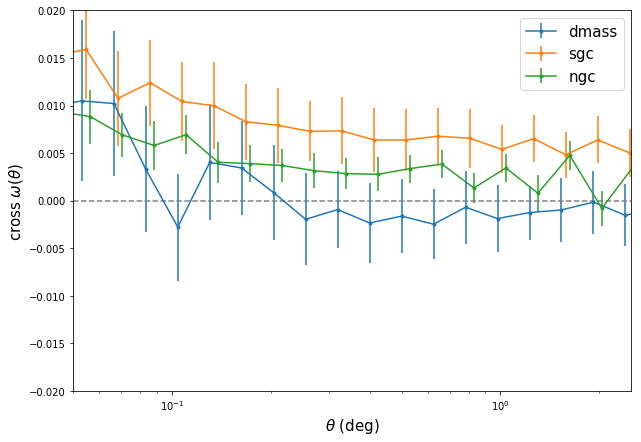

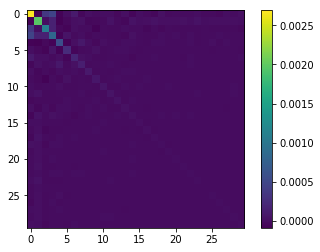

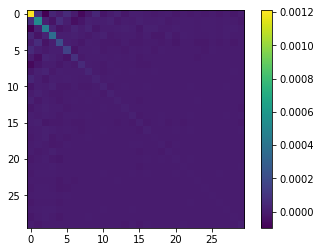

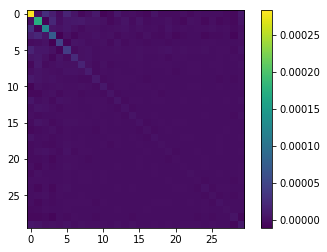

In [24]:

#dat1 = '../data_txt/acf_cross_agn_x_cmass_sgc_jk100'
#dat1 = '../data_txt/acf_cross_agn_x_cmass_ngc_jk200'
#dat1 = '../data_txt/acf_cross_agn_x_dmass_jk80'


#dat1 = '../data_txt/acf_auto_agn_ngc_jk200'

dat1 = '../data_txt/acf_cross_assef_agn_x_dmass_jk100'
#dat2 = '../data_txt/acf_cross_agn_x_dmass_jk100'
dat2 = '../data_txt/acf_cross_assef_agn_x_cmass_sgc_jk100'
dat3 = '../data_txt/acf_cross_assef_agn_x_cmass_ngc_jk100'
#dat2 = '../data_txt/acf_cross_agn_x_cmass_sgc_no1'
#dat2 = '../data_txt/acf_cross_agn_x_dmass_no1'


fig, ax = plt.subplots(figsize = (10,7))

meanr, xi, xi_err = np.loadtxt(dat1+'.txt', unpack=True)
meanr2, xi2, xi_err2 = np.loadtxt(dat2+'.txt',unpack=True)
meanr3, xi3, xi_err3 = np.loadtxt(dat3+'.txt',unpack=True)



cov = np.loadtxt(dat1+'.cov')
cov2 =  np.loadtxt(dat2+'.cov')
cov3 =  np.loadtxt(dat3+'.cov')
invcov = np.linalg.inv(cov)
invcov2 = np.linalg.inv(cov2)
invcov3 = np.linalg.inv(cov3)

ax.axhline(y=0, color='grey', linestyle='--')

ax.errorbar(meanr, xi, yerr = xi_err, fmt = '.-', label='dmass')
ax.errorbar(meanr2*1.03, xi2, yerr = xi_err2, fmt = '.-', label='sgc')
ax.errorbar(meanr3*1.06, xi3, yerr = xi_err3, fmt = '.-', label='ngc')


#corr_jk = np.loadtxt(dat1+'.jk_corr')
#for i in range(1, corr_jk[0,:].size): 
#    ax.plot(meanr*60, corr_jk[:,i], color = 'grey', alpha=0.05)

#ax.plot(theta * 60, wtheta_dmass_agn, 'k-')
#ax.plot(theta * 60, wtheta_cmass_agn, 'k-')

#inv = np.linalg.inv(xi_cov)   
    
    
ax.set_ylim(-0.02, 0.02)
ax.set_xlim(0.05, 2.5)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 15)
ax.set_ylabel(r'cross $\omega(\theta)$', fontsize = 15)
ax.legend(loc='best', fontsize = 15)

fig.subplots_adjust(wspace=0.2, hspace=0)


fig, ax = plt.subplots()
im = ax.imshow(cov)
fig.colorbar(im, ax=ax)

fig, ax = plt.subplots()
im = ax.imshow(cov2)
fig.colorbar(im, ax=ax)

fig, ax = plt.subplots()
im = ax.imshow(cov3)
fig.colorbar(im, ax=ax)


####################################################
####################################################



In [27]:
angular_correlation(data = agn_boss, 
                    rand = random_agn_boss, 
                    njack = 100,  
                    dir = '../data_txt/',
                    nbins = 20, min_sep = 0.005, max_sep = 1.0,
                    weight = [None, None], suffix = '_assef_agn_sgc_jk100' )

calculate angular correlation function
X (1315, 2)  centers (100, 2)  tol=1e-05  maxiter=200
13 iterations  cluster sizes: [ 8 17 22 12  9  9  8 20  9  7 16  5  8  7  7  6 10 12 21 10 14 13 13 24
 11  8 18 14 13 16 16  7 17  4 13 13 12  7 13 10  2 16 10  4 13 14 13 12
  5  3 14  9 11 26 20 16 21 10 12  7 20 21 13 24  7 14 14  8 12 31  7 16
  9 20 20 11  7 11 15 14 12  8 12 18  8 11 19 12 24 29 22  6 11 10 11 16
 12 22 15 26]
X (432942, 2)  centers (100, 2)  tol=1e-05  maxiter=200
165 iterations  cluster sizes: [2803 4279 5051 3284 3885 3555 4382 4495 4400 3335 4563 4043 2968 4494
 4378 4076 3813 3042 5420 4636 5027 4152 4081 4532 3556 3052 4862 4701
 5559 4660 5464 4085 4379 3534 3525 4825 4224 3498 4644 4223 3122 5022
 4265 4062 4123 4930 4431 4099 3626 3366 4432 4401 3568 5453 4737 4689
 4929 4590 4389 4977 4782 4565 4137 4957 3511 3628 4591 3590 4337 5130
 4176 4737 3668 4339 4648 3365 4935 4236 4461 5017 4621 3904 3789 4665
 3881 3696 3962 5433 4952 4146 5074 4697 4847 5049 3889 55

In [57]:
angular_correlation(data = agn_sgc, 
                    rand = random_agn_sgc, 
                    njack = 150,  
                    dir = '../data_txt/',
                    nbins = 20, min_sep = 0.005, max_sep = 1.0,
                    weight = [None, None], suffix = '_assef_agn_sgc_jk100' )

calculate angular correlation function
X (1315, 2)  centers (100, 2)  tol=1e-05  maxiter=200
16 iterations  cluster sizes: [16 15 20 13 11 16 15 18  5 17 17 15 14 12  8 13 16 14 11 15 17 15 18 12
 15 14 11 10 12 18 30 13 14  5 13 10 12 15 21 11 12 12 13 11 11 11 13  8
  9 15 15 15 14 19  7 13  6  9 11 17  9 12 16  7 16 14 19 20 11 10 14  8
 20 19 13  7 10 13  4 27 14  7  5 12 17 20  9 10 23 11 13 11  6 11  9 17
  6 11 10 16]
X (432942, 2)  centers (100, 2)  tol=1e-05  maxiter=200
86 iterations  cluster sizes: [5122 4409 4200 4601 4279 5624 3899 4730 4429 4741 4931 5036 3674 3292
 4593 3212 3774 4264 3421 4070 4071 4434 4872 4197 4517 4282 4222 4070
 3254 3439 4693 3757 4573 4578 4660 4256 3562 4620 4345 4522 4561 3875
 4180 4242 3295 4562 3637 3911 4206 5048 4254 5374 4572 3560 4378 4128
 4488 4092 4263 5211 3544 4201 4689 4694 4639 4626 4081 4954 4034 4490
 4610 3865 5255 5093 4038 3690 4851 3945 4032 5599 4396 3557 3990 4711
 4628 4088 3548 3902 4966 4965 4564 3995 5169 4111 4886 402

In [64]:
angular_correlation(data = agn_spt, 
                    rand = random_agn_spt, 
                    njack = 100,  
                    dir = '../data_txt/',
                    nbins = 20, min_sep = 0.005, max_sep = 1.0,
                    weight = [None, None], suffix = '_assef_agn_spt_jk100' )

calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
22 iterations  cluster sizes: [15 16  8  6  8 14 15 10 15 11  5  7  8  6 10 10 10  4 10 11  5  9  7 14
  6  8 14 19 13 14  5  6 11  9  9  9 13 17 12 13  8  8 13  9  9 21 15 12
 14  8 11 10 10  7  6  6 13  9  8 11  8 13  6  7  8  7 12  9  4  5 12 11
  8 11 13 10 11  9  5  3  9 14  5  9 10 11  3 14  9  8 11 16 14 23 12  7
 14  8  9  2]
X (177978, 2)  centers (100, 2)  tol=1e-05  maxiter=200
123 iterations  cluster sizes: [1424 2057 1958 1652 1944 2042 1976 1855 1407 1949 1886 1908 1951 1764
 1656 1712 1951 1173 2267 1918 1587 1508 1767 1358 1704 1865 2341 2279
 2046 2292 1902  647 1845 1696 1591 1682 2368 2100 1607 1453 1955 1370
 1227 1498 1071 1676 1511 1460 1865 1513 1557 1785 1399 1642 1337 1945
 1833 2255 1760 2161 1261 1772 1530 1317 1749 1801 1928 2261 1749 1651
 2160 1721 2326 1389 2323 1602 1709 1795 1772 2246 1546 1938 1595 1538
 2337 2154 1879 1770 1499 1777 2446 1745 1866 2594 1725 16

In [31]:
from systematics_module.corr import _corrfunc_acf_auto, _acf
#theta, wtheta_agn_spt = _corrfunc_acf_auto(agn_spt, random_agn_spt)
#theta, wtheta_agn_ngc = _corrfunc_acf_auto(agn_boss, random_agn_boss)
meanr, xi, xi_err = _acf(agn_spt, random_agn_spt, nbins = 20, min_sep = 0.005, max_sep = 1.0)
meanr2, xi2, xi_err2 = _acf(agn_sgc, random_agn_sgc, nbins = 20, min_sep = 0.005, max_sep = 1.0)
meanr3, xi3, xi_err3 = _acf(agn_boss, random_agn_boss, nbins = 20, min_sep = 0.005, max_sep = 1.0)

. . .


In [46]:
wtheta_agn_sgc

array([0.08795987, 0.0714599 , 0.06236687, 0.0489053 , 0.04441276,
       0.03738342, 0.03354222, 0.02961364, 0.02657355, 0.02334276,
       0.0211073 , 0.01964821, 0.01797693, 0.01644834, 0.01570505,
       0.01486825, 0.01427519, 0.01358278, 0.01290069, 0.01217902])

308.27996149315004
65.76917946635233


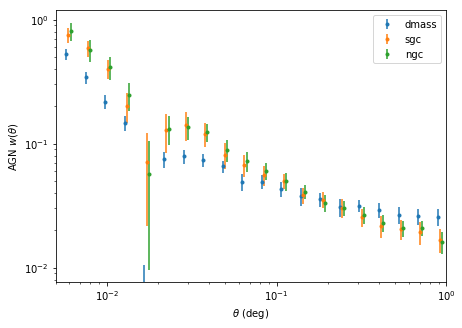

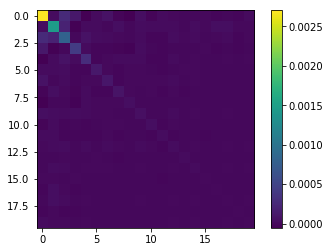

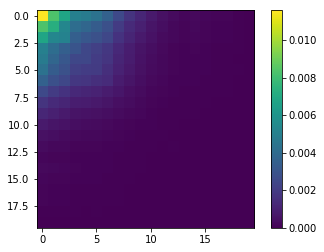

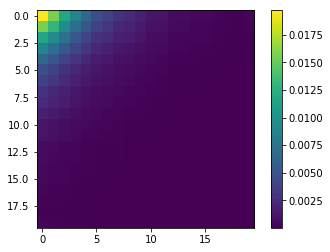

In [28]:

#dat1 = '../data_txt/acf_cross_agn_x_cmass_sgc_jk100'
#dat1 = '../data_txt/acf_cross_agn_x_cmass_ngc_jk200'
#dat1 = '../data_txt/acf_cross_agn_x_dmass_jk80'


#dat1 = '../data_txt/acf_auto_agn_ngc_jk200'

dat3 = '../data_txt/acf_auto_assef_agn_ngc_jk100'
dat2 = '../data_txt/acf_auto_assef_agn_sgc_jk100'
dat1 = '../data_txt/acf_auto_assef_agn_spt_jk100'
#dat2 = '../data_txt/acf_cross_agn_x_cmass_sgc_no1'
#dat2 = '../data_txt/acf_cross_agn_x_dmass_no1'


fig, ax = plt.subplots(figsize = (7,5))

meanr, xi, xi_err = np.loadtxt(dat1+'.txt', unpack=True)
meanr2, xi2, xi_err2 = np.loadtxt(dat2+'.txt',unpack=True)
meanr3, xi3, xi_err3 = np.loadtxt(dat3+'.txt',unpack=True)

cov = np.loadtxt(dat1+'.cov')
cov2 =  np.loadtxt(dat2+'.cov')
cov3 =  np.loadtxt(dat3+'.cov')
invcov = np.linalg.inv(cov)
invcov2 = np.linalg.inv(cov2)
invcov3 = np.linalg.inv(cov3)

ax.axhline(y=0, color='grey', linestyle='--')


ax.errorbar(meanr, xi, yerr = xi_err, fmt = '.', label='dmass')
ax.errorbar(meanr2*1.03, xi2, yerr = xi_err2, fmt = '.', label='sgc')
ax.errorbar(meanr3*1.06, xi3, yerr = xi_err3, fmt = '.', label='ngc')

#ax.set_ylim(-0.05, 0.08)
ax.set_xlim(0.005, 1.0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel(r'AGN $w(\theta)$')
ax.legend(loc='best')


fig.subplots_adjust(wspace=0.2, hspace=0)

#ax.plot(meanr*60, xi, 'k-', label='ngc')

#ax.plot(theta*60, wtheta_agn_spt, 'k-')
#ax.plot(theta*60, wtheta_agn_boss, 'k-')


diffv = (xi - xi2)
print np.dot(np.dot(diffv, invcov), diffv.T)#*1./xi.size
print np.dot(np.dot(diffv, invcov2), diffv.T)#*1./xi2.size


fig, ax = plt.subplots()
im = ax.imshow(cov)
fig.colorbar(im, ax=ax)

fig, ax = plt.subplots()
im = ax.imshow(cov2)
fig.colorbar(im, ax=ax)

fig, ax = plt.subplots()
im = ax.imshow(cov3)
fig.colorbar(im, ax=ax)